# TP Programmation avec Keras - Density Neural Network

Nous allons mettre en place un Density Neural Network afin d'effectuer une prédiction d'incertitudes.

Dans ce TP, des cellules seront laissées à trous, il faudra les compléter suivant les consignes. Elles seront identifiées par le mot **Exercice**. Les **Vérifications** seront effectuées principalement par vous-mêmes, sur la bonne convergence des algorithmes ou leur bon fonctionnement.

Ci-dessous, on importe les bibliothèques qui seront utiles.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf

## Mise en place des données

Afin de pouvoir visualiser simplement, nous allons utiliser des données en une dimension (entrée et sortie) : un cosinus bruité avec un bruit gaussien. Ci-dessous, nous mettons en place les données.

In [80]:
#NE PAS MODIFIER
N_train = 1000

X_train = np.random.rand(N_train)*8 - 4

sigma = np.abs(np.cos(X_train))*0.2

Y_train = np.cos(X_train) + np.random.normal(0, sigma)

N_test = 1000

X_test = np.linspace(-8,8,N_test)

Y_test = np.cos(X_test)

**Exercice** : Visualisez les données d'entraînement avec un scatter plot.

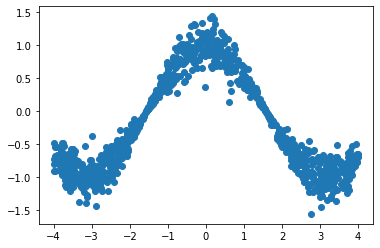

In [81]:
plt.scatter(X_train,Y_train)

## Création d'une couche de densité et d'une loss function associée

Nous allons supposer que la sortie suite une loi de probabilité $p(y|x)$ normale de moyenne $\mu$ et d'écart-type $\sigma$. Nous allons chercher à prédire ces paramètres $\mu$ et $\sigma$. Pour ce faire, nous allons créer un type de couche adapté à leur prédiction.

Ci-dessous, nous créons une couche DenseNormal qui prend entrée un nombre $N$ de neurones et produit $2N$ sorties : chaque dimension produit un $\mu$ et un $\sigma$.

**Exerice** : $\sigma$ doit être strictement positif. Pour ce faire, appliquez la fonction tf.nn.softplus à logsigma. Ajoutez en plus un petit $\varepsilon$ pour éviter des divergences lors de l'apprentissage (éviter que $\sigma$ ne s'approche trop de 0. 1e-6 devrait suffire.

In [82]:
class DenseNormal(keras.layers.Layer):
    def __init__(self, units):
        super(DenseNormal, self).__init__()
        self.units = int(units)
        self.dense = keras.layers.Dense(2 * self.units)

    def call(self, x):
        output = self.dense(x)
        mu, logsigma = tf.split(output, 2, axis=-1)
        sigma = tf.nn.softplus(logsigma) + 1e-6
        return tf.concat([mu, sigma], axis=-1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 2 * self.units)

    def get_config(self):
        base_config = super(DenseNormal, self).get_config()
        base_config['units'] = self.units
        return base_config

Nous allons créer ensuite la loss-function adaptée. Nous rappelons la vraisemblance de la loi gaussienne :

\begin{equation}
p(y|\mu,\theta) = \frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{(y-\mu)^2}{2\sigma^2}}
\end{equation}

La log-vraisemblance associée est donc donnée par :

\begin{equation}
\log(p(y|\mu,\theta)) = -\log(\sqrt{2\pi}\sigma) - (\frac{(y-\mu)^2}{2\sigma^2})
\end{equation}

**Exercice** : Complétez le code suivant en indiquant l'ensemble de la log-vraisemblance.


In [83]:
def Gaussian_NLL(y, net_output, reduce=True):
    mu, sigma = tf.split(net_output, 2, axis=-1)
    ax = list(range(1, len(y.shape)))

    logprob = -tf.math.log(sigma) - 0.5*tf.math.log(2*np.pi) - 0.5*((y-mu)/sigma)**2
    loss = tf.reduce_mean(-logprob, axis=ax)
    return tf.reduce_mean(loss) if reduce else loss

## Modèle Keras

### Création du modèle

**Exercice** : Créez un modèle avec Keras que vous appellerez "my_model", uniquement fully_connected. La dernière couche sera une couche DenseNormal que vous avez créée, avec un seul neurone puisqu'on prédit une sortie à 1 dimension.

In [84]:
my_model = keras.Sequential()
my_model.add(tf.keras.layers.Dense(64, activation="relu",input_shape = (1,)))
my_model.add(tf.keras.layers.Dense(64, activation="relu"))
my_model.add(DenseNormal(1))

**Exercice** : Affichez la structure de votre modèle avec my_model.summary()

In [85]:
my_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_normal_6 (DenseNormal) (None, 2)                 130       
Total params: 4,418
Trainable params: 4,418
Non-trainable params: 0
_________________________________________________________________


**Vérification** : Pour l'instant, il suffit qu'il n'y ait pas d'erreur.

### Compilation du modèle

**Exercice** : Il faut maintenant compiler le modèle en utilisant la fonction de coût que vous avez définie au-dessus avec la negative log-likelihood de la distribution gaussienne. Il suffit d'entrer le nom de la fonction en loss (sans guillemets). Il ne sera pas utile de mettre de métrique.

In [86]:
opt = keras.optimizers.Adam(lr = 0.001)
my_model.compile(optimizer = opt, loss = Gaussian_NLL)

**Vérification** : De nouveau, s'il n'y a pas d'erreur et que vous avez suivi les instructions, tout devrait bien se passer.

## L'apprentissage

**Exercice** : Effectuez classiquement l'apprentissage.

In [87]:
learning = my_model.fit(X_train,Y_train,epochs = 1000,batch_size = 100)

Epoch 1/1000
10/10 [==============================] - 0s 797us/step - loss: 1.4537
Epoch 2/1000
10/10 [==============================] - 0s 684us/step - loss: 0.9493
Epoch 3/1000
10/10 [==============================] - 0s 699us/step - loss: 0.7472
Epoch 4/1000
10/10 [==============================] - 0s 602us/step - loss: 0.6149
Epoch 5/1000
10/10 [==============================] - 0s 600us/step - loss: 0.5347
Epoch 6/1000
10/10 [==============================] - 0s 596us/step - loss: 0.4762
Epoch 7/1000
10/10 [==============================] - 0s 499us/step - loss: 0.4294
Epoch 8/1000
10/10 [==============================] - 0s 500us/step - loss: 0.3960
Epoch 9/1000
10/10 [==============================] - 0s 600us/step - loss: 0.3759
Epoch 10/1000
10/10 [==============================] - 0s 500us/step - loss: 0.3497
Epoch 11/1000
10/10 [==============================] - 0s 505us/step - loss: 0.3274
Epoch 12/1000
10/10 [==============================] - 0s 500us/step - loss: 0.3132
E

10/10 [==============================] - 0s 600us/step - loss: -0.5925
Epoch 193/1000
10/10 [==============================] - 0s 600us/step - loss: -0.6099
Epoch 194/1000
10/10 [==============================] - 0s 503us/step - loss: -0.6061
Epoch 195/1000
10/10 [==============================] - 0s 600us/step - loss: -0.6197
Epoch 196/1000
10/10 [==============================] - 0s 600us/step - loss: -0.6342
Epoch 197/1000
10/10 [==============================] - 0s 596us/step - loss: -0.6269
Epoch 198/1000
10/10 [==============================] - 0s 500us/step - loss: -0.6254
Epoch 199/1000
10/10 [==============================] - 0s 600us/step - loss: -0.6237
Epoch 200/1000
10/10 [==============================] - 0s 600us/step - loss: -0.6101
Epoch 201/1000
10/10 [==============================] - 0s 597us/step - loss: -0.6175
Epoch 202/1000
10/10 [==============================] - 0s 502us/step - loss: -0.6127
Epoch 203/1000
10/10 [==============================] - 0s 500us/step

10/10 [==============================] - 0s 1ms/step - loss: -0.6902
Epoch 384/1000
10/10 [==============================] - 0s 1ms/step - loss: -0.6912
Epoch 385/1000
10/10 [==============================] - 0s 1ms/step - loss: -0.6949
Epoch 386/1000
10/10 [==============================] - 0s 1ms/step - loss: -0.6870
Epoch 387/1000
10/10 [==============================] - 0s 1ms/step - loss: -0.6771
Epoch 388/1000
10/10 [==============================] - 0s 1ms/step - loss: -0.6759
Epoch 389/1000
10/10 [==============================] - 0s 1ms/step - loss: -0.6676
Epoch 390/1000
10/10 [==============================] - 0s 1ms/step - loss: -0.6629
Epoch 391/1000
10/10 [==============================] - 0s 1ms/step - loss: -0.6694
Epoch 392/1000
10/10 [==============================] - 0s 1ms/step - loss: -0.6860
Epoch 393/1000
10/10 [==============================] - 0s 1ms/step - loss: -0.6605
Epoch 394/1000
10/10 [==============================] - 0s 1ms/step - loss: -0.6673
Epoch 3

10/10 [==============================] - 0s 600us/step - loss: -0.7035
Epoch 576/1000
10/10 [==============================] - 0s 501us/step - loss: -0.7052
Epoch 577/1000
10/10 [==============================] - 0s 600us/step - loss: -0.6980
Epoch 578/1000
10/10 [==============================] - 0s 600us/step - loss: -0.7113
Epoch 579/1000
10/10 [==============================] - 0s 600us/step - loss: -0.7060
Epoch 580/1000
10/10 [==============================] - 0s 600us/step - loss: -0.7062
Epoch 581/1000
10/10 [==============================] - 0s 500us/step - loss: -0.7068
Epoch 582/1000
10/10 [==============================] - 0s 600us/step - loss: -0.7211
Epoch 583/1000
10/10 [==============================] - 0s 905us/step - loss: -0.7128
Epoch 584/1000
10/10 [==============================] - 0s 700us/step - loss: -0.7048
Epoch 585/1000
10/10 [==============================] - 0s 900us/step - loss: -0.7145
Epoch 586/1000
10/10 [==============================] - 0s 1ms/step -

10/10 [==============================] - 0s 500us/step - loss: -0.7212
Epoch 672/1000
10/10 [==============================] - 0s 500us/step - loss: -0.7204
Epoch 673/1000
10/10 [==============================] - 0s 500us/step - loss: -0.7235
Epoch 674/1000
10/10 [==============================] - 0s 498us/step - loss: -0.7239
Epoch 675/1000
10/10 [==============================] - 0s 500us/step - loss: -0.7108
Epoch 676/1000
10/10 [==============================] - 0s 515us/step - loss: -0.7183
Epoch 677/1000
10/10 [==============================] - 0s 500us/step - loss: -0.7173
Epoch 678/1000
10/10 [==============================] - 0s 500us/step - loss: -0.6978
Epoch 679/1000
10/10 [==============================] - 0s 498us/step - loss: -0.7148
Epoch 680/1000
10/10 [==============================] - 0s 500us/step - loss: -0.7193
Epoch 681/1000
10/10 [==============================] - 0s 700us/step - loss: -0.6903
Epoch 682/1000
10/10 [==============================] - 0s 500us/step

10/10 [==============================] - 0s 502us/step - loss: -0.7192
Epoch 862/1000
10/10 [==============================] - 0s 500us/step - loss: -0.7211
Epoch 863/1000
10/10 [==============================] - 0s 542us/step - loss: -0.7047
Epoch 864/1000
10/10 [==============================] - 0s 488us/step - loss: -0.7163
Epoch 865/1000
10/10 [==============================] - 0s 599us/step - loss: -0.7139
Epoch 866/1000
10/10 [==============================] - 0s 600us/step - loss: -0.7233
Epoch 867/1000
10/10 [==============================] - 0s 500us/step - loss: -0.7296
Epoch 868/1000
10/10 [==============================] - 0s 500us/step - loss: -0.7211
Epoch 869/1000
10/10 [==============================] - 0s 500us/step - loss: -0.7172
Epoch 870/1000
10/10 [==============================] - 0s 500us/step - loss: -0.7122
Epoch 871/1000
10/10 [==============================] - 0s 600us/step - loss: -0.7040
Epoch 872/1000
10/10 [==============================] - 0s 600us/step

**Vérification** : La loss function devrait diminuer.

**Exercice** : Tracez l'évolution de la fonction de coût.

Text(0.5, 1.0, 'Loss function evolution')

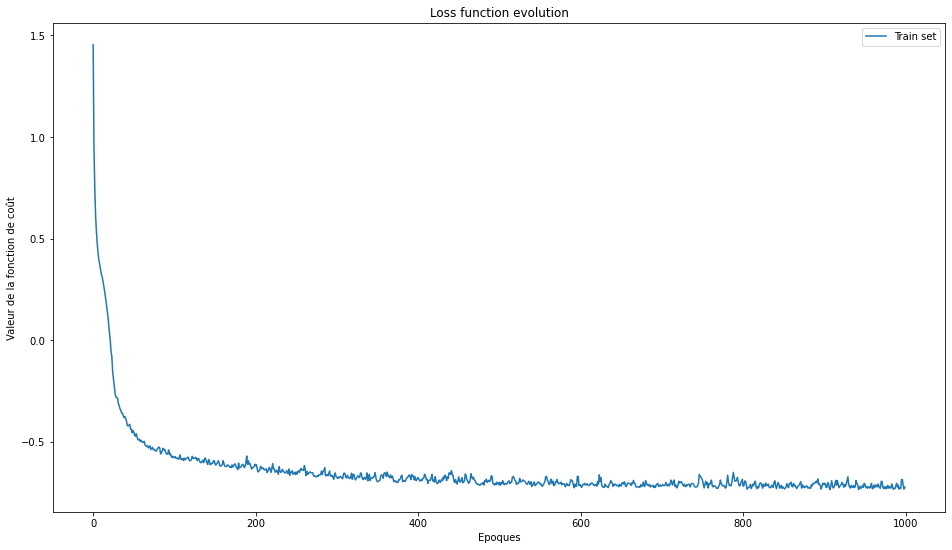

In [88]:
loss_evolution = learning.history["loss"]


plt.figure(figsize = (16,9))
plt.plot(loss_evolution,label = "Train set")
plt.xlabel("Epoques")
plt.ylabel("Valeur de la fonction de coût")
plt.legend()
plt.title("Loss function evolution")


## Prédictions avec le modèle

**Exercice** : Effectuez une prédiction à partir de X_test.

In [89]:
Y_pred_test = my_model.predict(X_test)

**Exercice** : Séparez la prédiction en deux vecteurs mu et sigma.

In [90]:
mu = Y_pred_test[:,0]
sigma = Y_pred_test[:,1]

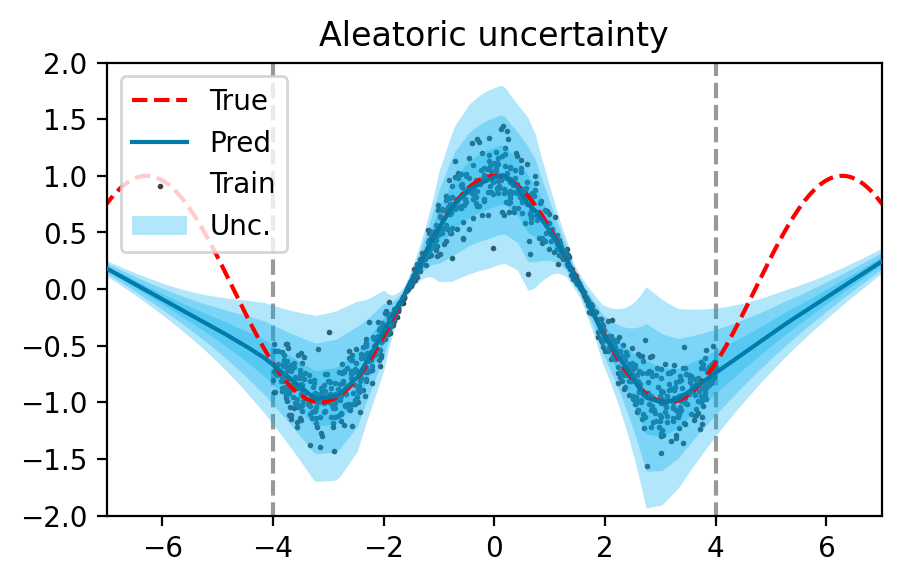

In [93]:
var = np.minimum(sigma, 1e3)
    
plt.figure(figsize=(5, 3), dpi=200)
plt.title("Aleatoric uncertainty")
plt.scatter(X_train, Y_train, s=1., c='#463c3c', zorder=0, label="Train")
plt.plot(X_test, Y_test, 'r--', zorder=2, label="True")
plt.plot(X_test, mu, color='#007cab', zorder=3, label="Pred")
plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)
for k in np.linspace(0, 4, 4):
    plt.fill_between(
        X_test, (mu - k * var), (mu + k * var),
        alpha=0.3,
        edgecolor=None,
        facecolor='#00aeef',
        linewidth=0,
        zorder=1,
        label="Unc." if k == 0 else None)
plt.gca().set_ylim(-2, 2)
plt.gca().set_xlim(-7, 7)
plt.legend(loc="upper left")